## Anomaly Detection - Compare all Models with Output

In [1]:
%reload_ext autoreload
%autoreload 2
import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import ts_utils
import ts_plot_utils

import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model


mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")

Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


## Prepare Data

In [2]:
import glob
import numpy as np

def checkFirstColumnIsTime(df ):
    if (df.columns[0] != 'time'):
        v = df.iloc[0,0]
        print("Changing the first columns to time and converting to ms", v)
        
        df.columns = ['time'] + [c for c in df.columns[1:]]
        df['time'] = pd.to_datetime(df.time).map(lambda x: int(x.timestamp()*1000) ) 
    return df

def add_perodictime(df, day=1, quarter=1, year= 1):
    day = 24*60*60
    quarter = 4 * 30 * day
    year = (365.2425)*day

    if ( 'time' in df.columns):
        timestamp_s = df['time'] / 1000  # = > get it in seconds
    else:
        timestamp_s = df.index / 1000  # = > get it in seconds

    if ( day):
        df['Day_sin']     = np.sin(timestamp_s * (2 * np.pi / day))
        df['Day_cos']     = np.cos(timestamp_s * (2 * np.pi / day))
    if ( quarter):
        df['Quarter_sin'] = np.sin(timestamp_s * (2 * np.pi / quarter))
        df['Quarter_cos'] = np.cos(timestamp_s * (2 * np.pi / quarter))
    if ( year):
        df['Year_sin']    = np.sin(timestamp_s * (2 * np.pi / year))
        df['Year_cos']    = np.cos(timestamp_s * (2 * np.pi / year))

    return df;

#Comments Othe things you may do 
'''
    => Drop highly corrlated sensors for post-mortem analysis
    => Drop time correlated sensors 
    => reduce the frequency 
    => Add periodic sensors for day, month, quarter, year
'''
def read_data(files="/tmp/test/*.csv", dropna=True ):
    li=[]
    for f in (glob.glob(files)):
        df = pd.read_csv(f, index_col=None, header=0)
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.reset_index(inplace=True, drop=True)

    if dropna:
        df.dropna(inplace=True)
    df = df.ffill().bfill().fillna(0)    # <= we would already dropped NAs before

    df = checkFirstColumnIsTime(df)
    df.index= df['time']
    df.drop('time', axis=1, inplace=True, errors="ignore")

    return df



In [3]:
import ts_transform
from ts_transform import myColumnTransformer


# Read the file
files = "/tmp/test/*.csv"
df = read_data(files=files, dropna=True )
df = add_perodictime(df)

split  = int(len(df) * .7)

df1 = df
df_trn1  = df[df.columns[1:]][:split]
df_tst1  = df[df.columns[1:]][split:]

# See ts_transofrm for more details on how to use this
scaler, df_trn = myColumnTransformer.scale_df(df_trn1)
df_tst = scaler.transform(df_tst1)
df_trn.index = df_trn1.index
df_tst.index = df_tst1.index
scaler.save(os.path.dirname(files) + "/SCALER." )  # <== we can read this later if we wanted to 
df_tst

Changing the first columns to time and converting to ms 2/27/22 12:00


,zpw,zf,pf,zpm,cf,cs2,xpw,yltime,yf,xl,...,bl,zl,Day_sin,Day_cos,Quarter_sin,Quarter_cos,Year_sin,Year_cos,cat1_A,cat1_B
time,,,,,,,,,,,,,,,,,,,,,
1647968580000,0.423766,-0.494459,-0.305052,0.694147,-0.060026,-0.577536,0.584397,1.933925,-0.250436,0.593439,...,1.502774,-0.298015,-1.368935,-0.314296,2.373761,1.592736,1.588389,-1.980019,1.0,0.0
1647968760000,0.423766,-0.494459,-0.305052,0.694147,-0.060026,-0.577536,0.584397,1.934125,-0.250436,0.593439,...,1.502774,-0.298015,-1.373378,-0.296329,2.374290,1.592868,1.588540,-1.980361,1.0,0.0
1647968940000,0.423766,-0.494459,-0.305052,0.694147,-0.060026,-0.577536,0.584397,1.934507,-0.250436,0.593439,...,1.502774,-0.298015,-1.377585,-0.278305,2.374818,1.593000,1.588691,-1.980704,1.0,0.0
1647969120000,0.423766,-0.494459,-0.305052,0.694147,-0.060026,-0.577536,0.584397,1.934783,-0.250436,0.593439,...,1.502774,-0.298015,-1.381556,-0.260227,2.375347,1.593132,1.588842,-1.981046,1.0,0.0
1647969300000,0.423766,-0.494459,-0.305052,0.694147,-0.060026,-0.577536,0.584397,1.935146,-0.250436,0.593439,...,1.502774,-0.298015,-1.385289,-0.242100,2.375876,1.593264,1.588993,-1.981389,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648727100000,-0.469652,2.789292,0.969362,0.224435,-0.012577,-0.572008,0.584399,3.289958,-0.221374,0.115265,...,1.971064,1.403829,0.095457,-1.377108,4.695996,1.762239,1.952588,-3.437401,0.0,1.0
1648727280000,-1.543985,2.158439,-0.169628,-1.122967,-0.036303,1.777861,-1.422758,3.290210,-0.028996,0.020228,...,0.361317,-0.131919,0.076962,-1.378198,4.696550,1.762185,1.952610,-3.437749,0.0,1.0
1648727460000,-1.402788,-0.406083,-0.294058,-1.419442,-0.060026,1.764920,-1.624495,3.290616,-0.250436,-0.739010,...,-0.604531,-0.349121,0.058454,-1.379045,4.697104,1.762132,1.952631,-3.438097,0.0,1.0


In [4]:
input_slice  = slice(0, len(df_trn.columns))    
label_slice  = slice(0, len(scaler.numerics))     # output columns 
window_len   = 48
ouput_len    = 1
batch_size   = 20

ouput_feat_len  = label_slice.stop - (label_slice.start or 0)
model_op_len    = ouput_feat_len * ouput_len

ds_trn = tf.data.Dataset.from_tensor_slices(df_trn[df_trn.columns[input_slice]])
ds_tst = tf.data.Dataset.from_tensor_slices(df_tst[df_tst.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)
window_tst = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)
window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000, skip=0)
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000, skip=0)

inp_feat_len    = input_slice.stop - (input_slice.start or 0)

In [11]:
ouput_feat_len

33

## Various Models

In [39]:
performance = {}
models = []

In [40]:
# Linear Model
model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :])
    ] + ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "Linear"
)
models.append(model)



In [41]:
# LSTM Model
model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].

        tf.keras.layers.LSTM(64, return_sequences=False)
    ]+ ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "LSTM"
)
models.append(model)

In [45]:
# Uber Model
dim = 128

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (dim//2, return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (dim//2, return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    recurrent_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    return_sequences=False)(concat_layer)

# => Note this is same as getCommonLayer(ouput_len, ouput_feat_len, memory_layer)
#
# preds = Dense(units=ouput_feat_len*ouput_len)(memory_layer)
preds = Dense(units=ouput_feat_len*ouput_len, activation='linear')(memory_layer)
preds = tf.keras.layers.Reshape([ouput_len, ouput_feat_len])(preds)
model = Model(input_layer, preds, name="Uber")

# => Lets not do Uber model it takes long time to build this model

#models.append(model)
#history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=1, verbose=1)


490/490 [==============================] - 150s 291ms/step - loss: 0.5481 - mean_absolute_error: 0.3608 - val_loss: 0.9155 - val_mean_absolute_error: 0.6236


In [43]:
#Simple RNN
srnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40)]
    + ts_utils.getCommonLayer(ouput_len, ouput_feat_len)
    , name="SimpleRNN")

models.append(srnn_model)

# Add a Dense Layer
dlinear_model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        tf.keras.layers.Dense(512, activation='relu')
    ] +  ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "DenseLinear"
)
models.append(dlinear_model)


# CNN
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    ] + ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "Conv"
)
models.append(conv_model)

## Transformer

In [ ]:
import tensorflow as tf
# https://www.tensorflow.org/text/tutorials/transformer

class Time2Vec(tf.keras.layers.Layer):
    def __init__(self,d_model):
        super().__init__()

        self.linear = tf.keras.layers.Dense(1)
        self.temp =  tf.keras.layers.Dense(d_model-1)
    
    def call(self,x):
        x1 = self.linear(x)
        x2 = tf.math.sin(self.temp(x))
        return tf.concat([x1,x2],axis = -1)

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class SelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = SelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
               target_length,target_dim,windowL, dropout_rate=0.1):
        super().__init__()

        self.num_layers = num_layers
        self.target_length = target_length
        self.target_dim = target_dim
        self.t2v = Time2Vec(d_model)
        self.blocks = [TransformerBlock(d_model=d_model,num_heads=num_heads,dff=dff) for _ in range(num_layers)]
        self.reshape = tf.keras.layers.Flatten()
        self.forecast =  tf.keras.layers.Dense(target_length*target_dim)
        self.windowL = windowL
        self.target_dim = target_dim


    def call(self,x):
        
        B,L,D = x.shape
        x = self.t2v(x)

        for i in range(self.num_layers):
            x  = self.blocks[i](x)

        # x =tf.reshape(x,(B, -1))
        x = self.reshape(x)
        x = self.forecast(x)

        if self.target_length > 1:

            x = tf.reshape(x,(B,self.target_length,self.target_dim))

        return x
    
    def build_graph(self):
        x = tf.keras.Input(shape=(self.windowL,self.target_dim))
        return tf.keras.Model(inputs = x,outputs = self.call(x))

## Compile and Evaluate All Models

209/209 [==============================] - 0s 2ms/step - loss: 0.6144 - mean_absolute_error: 0.5315


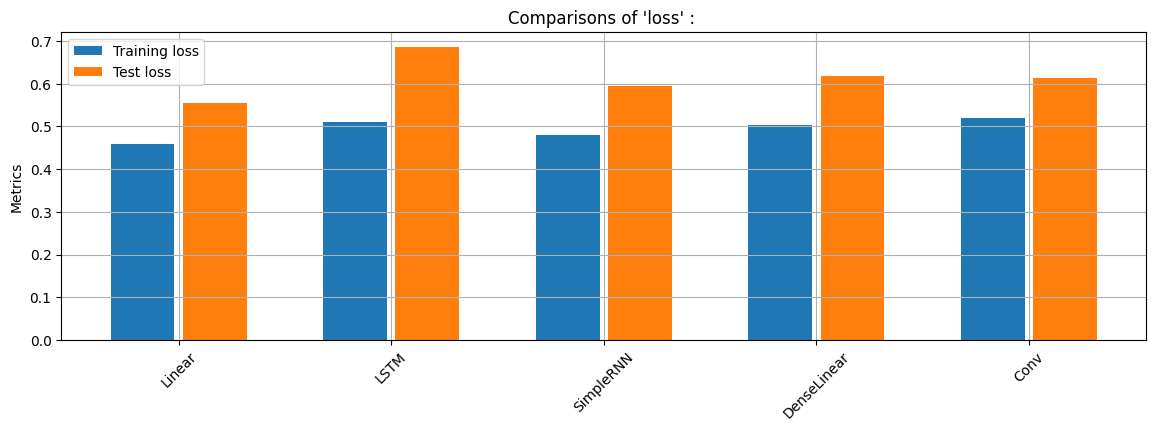

In [44]:
for i, model in enumerate(models):
    print(f"Now Compiling {i+1}/{len(models)} {model.name} ")
    history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=3, verbose=1)
    IPython.display.clear_output()

# Plot graphs
performance = ts_plot_utils.plot_performance(models, window_trn, window_tst, performance=performance)

## Model Architecture

PLotting 0 Model: Linear


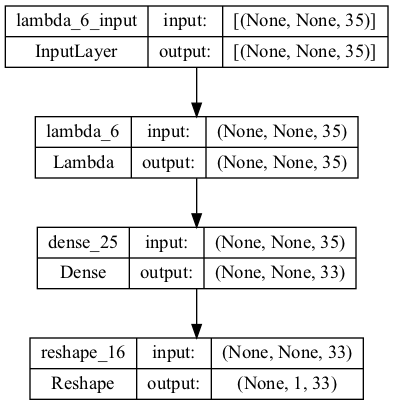

PLotting 1 Model: LSTM


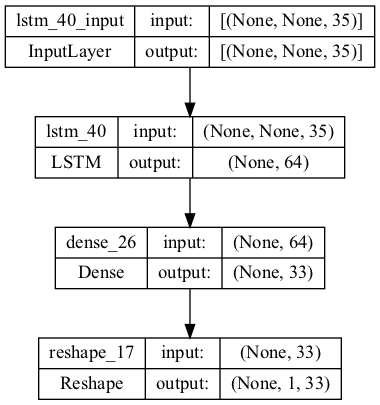

PLotting 2 Model: SimpleRNN


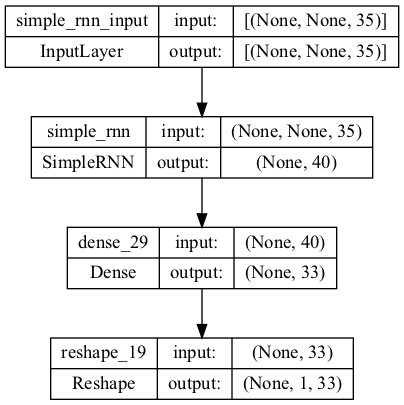

PLotting 3 Model: DenseLinear


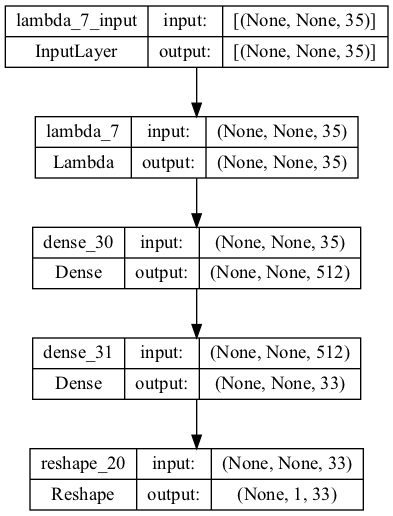

PLotting 4 Model: Conv


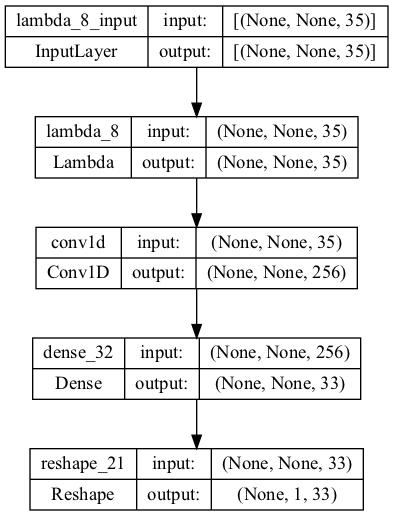

In [75]:
from keras.utils import plot_model
for i, model in enumerate(models):
    print(f"PLotting {i} Model: {model.name}")
    d= plot_model(model, show_shapes=True)
    display(d)

## Predictions

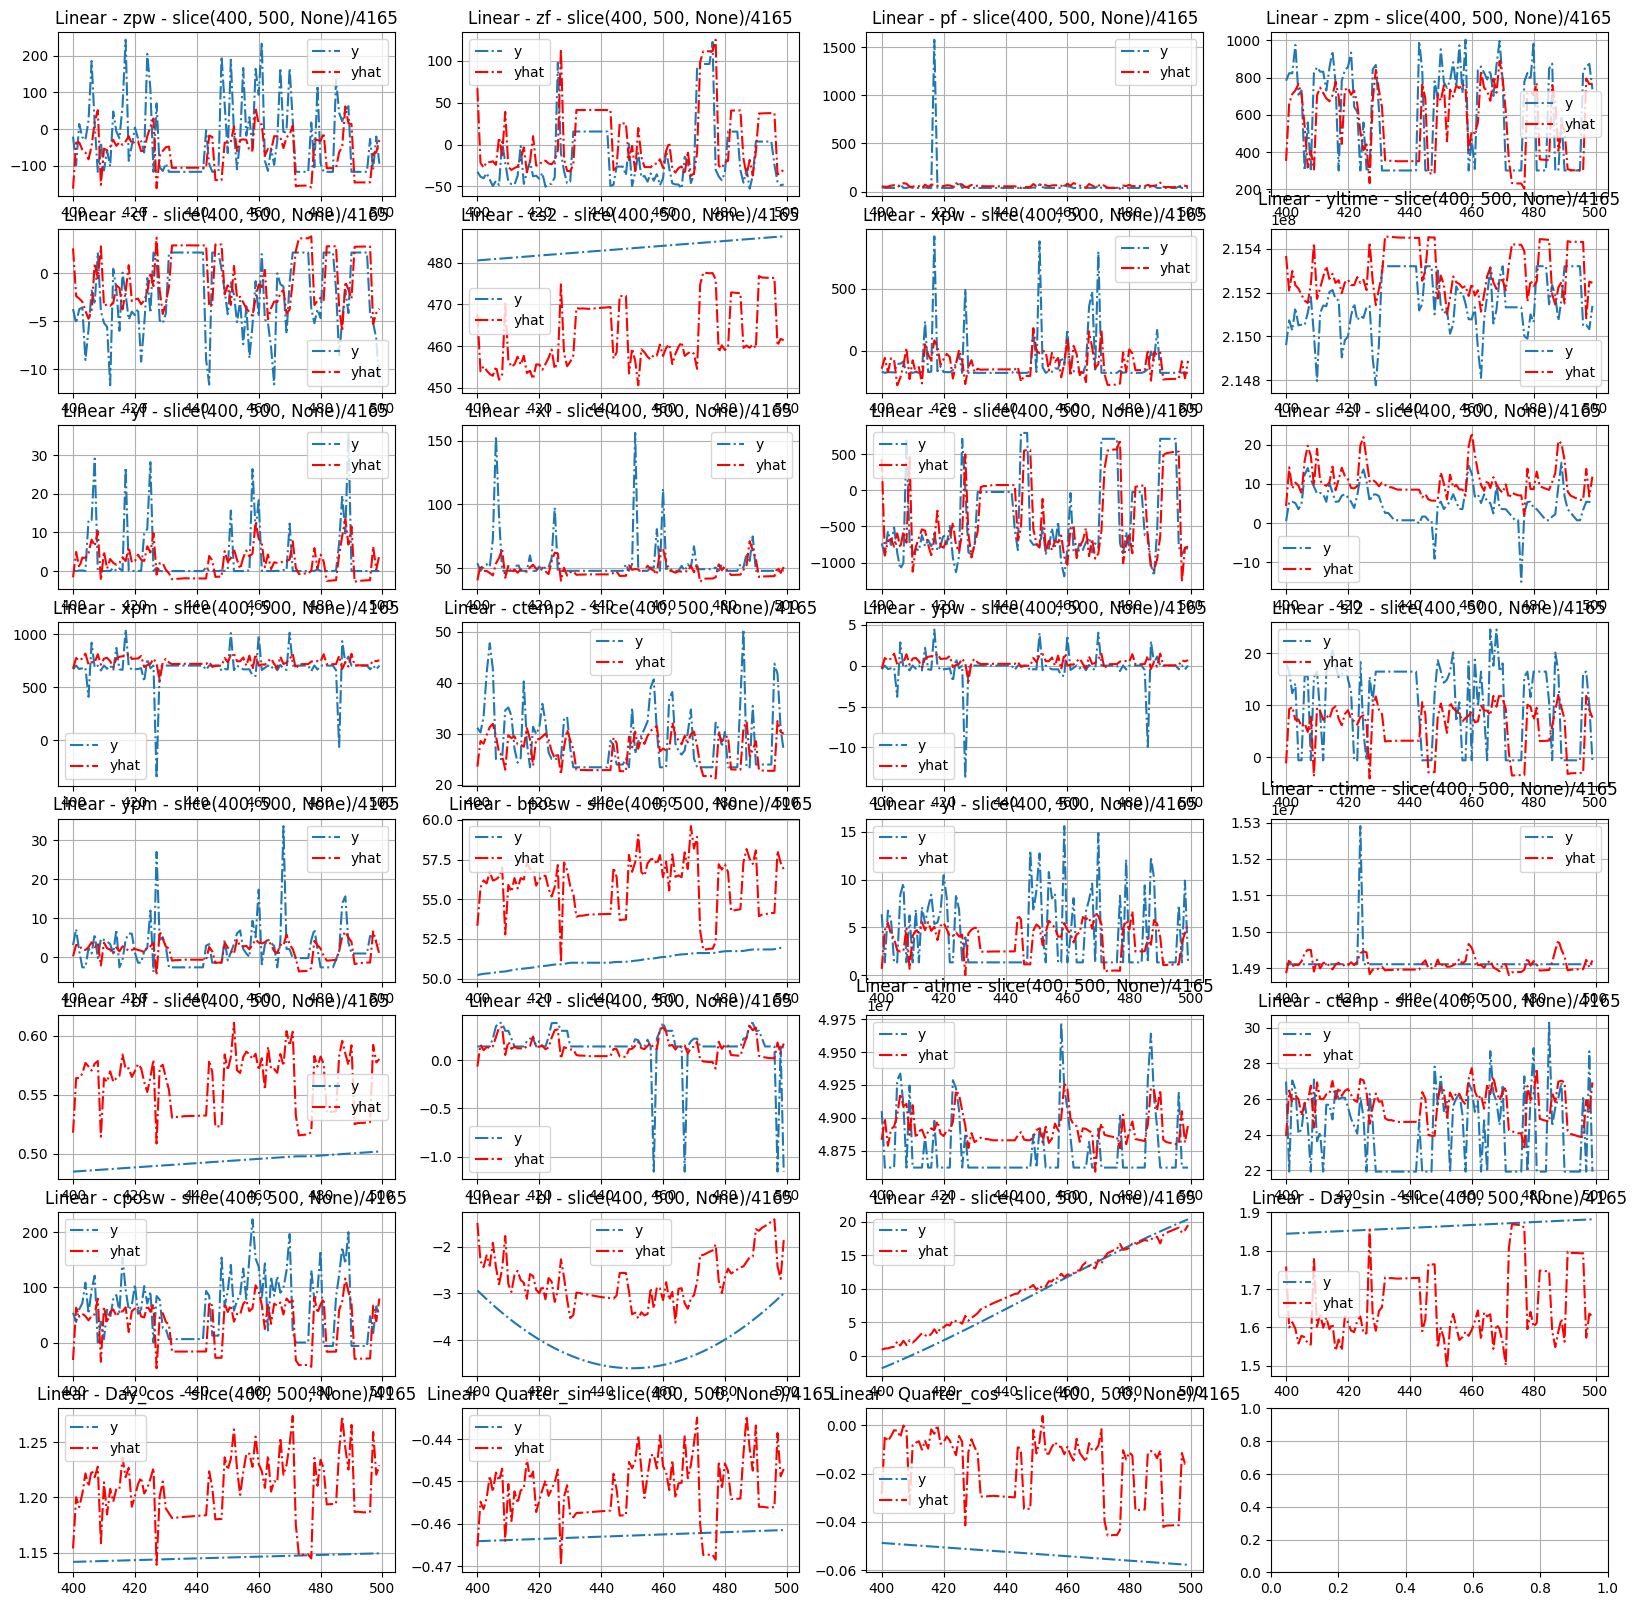

In [76]:
import matplotlib.pyplot as plt

model = models[0]
rw=slice(400, 500)
pc = 4

y, yhat = ts_utils.model_predict( model , window_tst100)
ydf = scaler.inverse_transform(pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice]))
pdf = scaler.inverse_transform(pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice]))

nc = len(ydf.columns)
pr = nc //pc + 1 if len(ydf.columns)%pc else 0
fig, axs = plt.subplots(pr, pc, figsize=(20, 5 *pc))
for i, c in enumerate(ydf.columns):
    pr1 , pc1 = i // pc, i % pc
    plt1 = axs[ pr1, pc1 ]
    plt1.plot(range(len(ydf))[rw], ydf[c][rw], "-."  , label=f"y")
    plt1.plot(range(len(pdf))[rw], pdf[c][rw], "r-." , label=f"yhat")
    plt1.legend()
    plt1.set_title(f'{model.name} - {c} - {rw}/{len(ydf)}')

In [ ]:
#model = models[1]
#ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
#                        plot_start=0, df=None, scaler=None, label_slice=None);

## Anomaly graph

### The END